Implementing Customer Segmentation using RFM analysis with PySpark

Customer segmentation is a marketing tool to group your customers based on common characteristics so that you can focus and market to each group effectively and maximize the value of each customer to the business.

Like so many other disciplines, in business as well, we see that old 80–20 rule. Where 80% of your revenue comes from 20% of your customers. That’s why to increase your business you need to understand your customer.


There are at least two main goals of customer segmentation:

    Continue to provide the best service to your best customers.
    Focus on prospective customers who resemble your best customers.

     ∘ RFM Model
      ∘ Dataset
      ∘ Recency, Frequency & Monetary value calculation
      ∘ RFM score calculation
      ∘ Segmentation based on RFM Score
      ∘ Segmentation results
      ∘ Conclusion

RFM Model:

RFM stands for recency, frequency, and monetary, and this is a highly flexible managerial customer segmentation model.

In [1]:
from pyspark.sql import SparkSession
import gc
import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName('RFM Model').getOrCreate()
data = spark.read.csv("OnlineRetail.csv", inferSchema = True, header=True)
print('Dataframe dimensions:', (data.count(), len(data.columns)))
data.show(5)

22/04/25 06:35:13 WARN Utils: Your hostname, sp-pc resolves to a loopback address: 127.0.1.1; using 172.29.34.215 instead (on interface eth0)
22/04/25 06:35:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/25 06:35:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataframe dimensions: (541909, 8)
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [2]:
def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

nullcount(data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 1454,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 135080,
 'Country': 0}

In [3]:
data.toPandas().describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Recency, Frequency & Monetary value calculation:

The first thing we’ll calculate is the three key factors of RFM Analysis (recency, frequency, and monetary).

    Recency: How recently customers made their purchase.
    Frequency: For simplicity, we’ll count the number of times each customer made a purchase.
    Monetary: How much money they spent in total.

We are going to calculate these three key factors by grouping them by customers and taking “2011/12/10” as our reference end date since this is the last transaction date listed in our dataset.

In [4]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [5]:
data.columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [6]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

In [7]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct()\
    .groupBy("Country")\
    .agg(F.count("CustomerID").alias("Count"))\
    .withColumn('Total', F.sum('Count').over(Window.partitionBy()))\
    .withColumn('%', (F.col('Count')/F.col('Total'))*100)\
    .sort("Count", ascending=False)

printdf(rtl_data)

22/04/25 06:35:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 06:35:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 06:35:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 06:35:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/25 06:35:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,Country,Count,Total,%
0,United Kingdom,3950,4380,90.182648
1,Germany,95,4380,2.168950
2,France,87,4380,1.986301
3,Spain,31,4380,0.707763
4,Belgium,25,4380,0.570776


Looks like 90% of the customers are from UK
So, from now on we'll consider only UK's customers

In [8]:
# Consider only customers from UK
rtl_data = data.filter(F.col("Country") == "United Kingdom")

# Filter out null customer ids
rtl_data = rtl_data.filter(F.col("CustomerID").isNotNull())
print(rtl_data.count())
printdf(rtl_data)

361878


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [9]:
# Other approach to check null counts
nullcount(rtl_data)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 0,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 0,
 'Country': 0}

In [10]:
# Explore the schema of the dataframe
rtl_data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [11]:
# See basic stats of numeric columns
rtl_data.toPandas().describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


When you run describe, always look for negative quantiles, remove them

In [12]:
printdf(rtl_data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [13]:
# Remove negative Quantities
rtl_data = rtl_data.filter(F.col("Quantity") > 0)

# Introduce Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", F.round(F.col("Quantity") * F.col("UnitPrice")))

# Reformat invoice date to yyyy-MM-dd

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
rtl_data = rtl_data.withColumn("InvoiceDate", F.to_date(F.col("InvoiceDate"), 'MM/dd/yyyy'))

printdf(rtl_data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.0


In [14]:
# Max and Min Date

df = rtl_data.toPandas()

print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

2010-12-01
2011-12-09


# RFM Modeling

In [16]:
rtl_data.select(F.max('InvoiceDate')).collect()

[Row(max(InvoiceDate)=datetime.date(2011, 12, 9))]

In [17]:
# Recency   = Overall latest invoice date - individual customer's last invoice date
# Frequency = count of invoice no. of transaction(s)
# Monetary = Sum of Total amount for each customer

# Set 2011/12/10 as the overall last invoice date. This is to calculate recency in days.
latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

# Create RFM Modelling scores for each customer


####### Approach One
rfm_scores = (rtl_data.groupBy("CustomerID")
              .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"),
                   F.count("*").alias("Frequency"),
                   F.sum(F.col("TotalAmount")).alias("Monetary")).sort("CustomerID"))


###### Approach Two
# recency = (
#     rtl_data.groupBy("CustomerID")
#             .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Recency"))
# )

# frequency = (
#     rtl_data.groupBy("CustomerID", "InvoiceNo").count()
#             .groupBy("CustomerID")
#             .agg(F.count("*").alias("Frequency"))
# )

# monetary = (
#     rtl_data.groupBy("CustomerID")
#             .agg(F.sum(F.col("TotalAmount")).alias("Monetary"))
# )

# rfm_scores = (
#     recency.join(frequency, 'CustomerID', how = 'inner')
#            .join(monetary,'CustomerID', how = 'inner')
# )

printdf(rfm_scores)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77184.0
1,12747,3,103,4207.0
2,12748,1,4596,33956.0
3,12749,4,199,4115.0
4,12820,4,59,946.0


In [18]:
rfm_scores.toPandas().describe()

,CustomerID,Recency,Frequency,Monetary
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.722265,90.371079,1870.640653
std,1576.823683,99.528532,217.796155,7485.207270
min,12346.000000,1.000000,1.000000,0.000000
25%,14208.000000,18.000000,17.000000,301.000000
50%,15569.000000,51.000000,41.000000,654.000000
75%,16913.000000,143.000000,99.000000,1587.000000
max,18287.000000,374.000000,7847.000000,259665.000000


Explore RFM Scores using SNS

In [19]:
rfm_scores_df = rfm_scores.toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

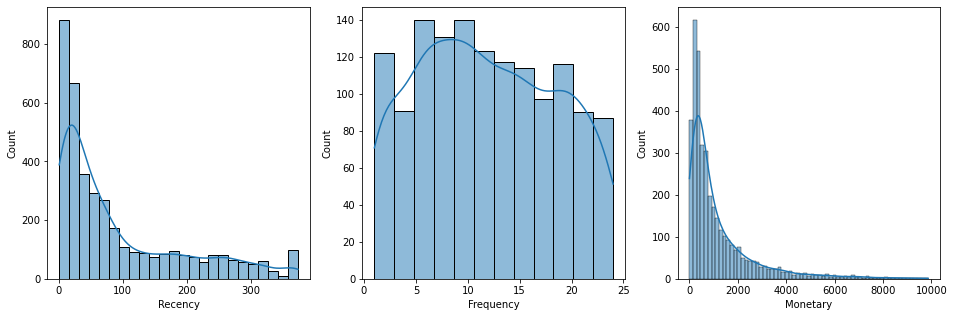

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df.query('Frequency < 25')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])


Save RFM numbers

In [29]:
rfm_scores_df.to_csv('retail_rfm_numbers.csv', index=False)

Calculate RFM Scores

In [30]:
# We are going to divide our customer base into 3 segments: 
#    1st segment: top 20%
#    2nd segment: 20% - 60%
#    3rd segment: bottom 40%

# Understand and calculate different quantiles

segments = [0.33, 0.66]

quantiles = rfm_scores.approxQuantile(
    ["Recency", "Frequency", "Monetary"], 
    segments,
    0)

quantiles

[[25.0, 89.0], [23.0, 71.0], [372.0, 1114.0]]

In [31]:
# Calculate R,F,M scores considering 3 quantiles

rfm_scores = (rfm_scores
    .withColumn("R_Score",
                F.when(F.col("Recency") < quantiles[0][0], F.lit(1))
                 .when(F.col("Recency") < quantiles[0][1], F.lit(2))
                 .otherwise(F.lit(3)))
    .withColumn("F_Score",
                F.when(F.col("Frequency") < quantiles[1][0], F.lit(3))
                 .when(F.col("Frequency") < quantiles[1][1], F.lit(2))
                 .otherwise(F.lit(1)))
    .withColumn("M_Score",
                F.when(F.col("Monetary") < quantiles[2][0], F.lit(3))
                 .when(F.col("Monetary") < quantiles[2][1], F.lit(2))
                 .otherwise(F.lit(1))))

# printdf(rfm_scores.filter(F.col("CustomerID").isin([12346,12747,12748,12749,12820])))
printdf(rfm_scores)

# rfm_scores.describe().show()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,326,1,77184.0,3,3,1
1,12747,3,103,4207.0,1,1,1
2,12748,1,4596,33956.0,1,1,1
3,12749,4,199,4115.0,1,1,1
4,12820,4,59,946.0,1,2,2


In [32]:
# Aggregate RFM scores

rfm_agg_scores = (
    rfm_scores
    .withColumn("RFM_Score", F.col("R_Score") + F.col("F_Score") + F.col("M_Score"))
    .withColumn("RFM_ScoreGroup", F.concat(F.col("R_Score").cast(StringType()), F.col("F_Score").cast(StringType()), F.col("M_Score").cast(StringType())))
)

printdf(rfm_agg_scores)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup
0,12346,326,1,77184.0,3,3,1,7,331
1,12747,3,103,4207.0,1,1,1,3,111
2,12748,1,4596,33956.0,1,1,1,3,111
3,12749,4,199,4115.0,1,1,1,3,111
4,12820,4,59,946.0,1,2,2,5,122


In [33]:
df_rfm_agg_scores = rfm_agg_scores.toPandas()
df_rfm_agg_scores.shape

(3921, 9)

<AxesSubplot:xlabel='RFM_ScoreGroup', ylabel='count'>

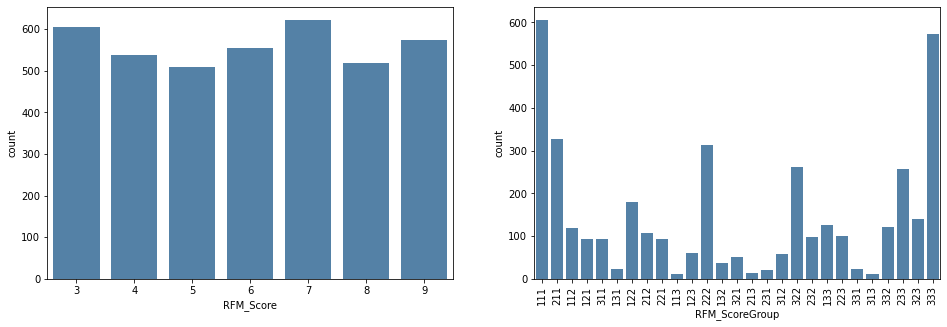

In [35]:
# Inspect RFM

df_rfm_agg_scores = df_rfm_agg_scores.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=df_rfm_agg_scores, color='steelblue', ax=ax[0])
sns.countplot(x="RFM_ScoreGroup", data=df_rfm_agg_scores, color='steelblue', ax=ax[1])
# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

# Segmentation 1

In [36]:
# Identify the three segments again based on RFMScore (33% in each segment)
segments = [0.33, 0.66]
quantiles = rfm_agg_scores.approxQuantile("RFM_Score", segments, 0)
quantiles

[5.0, 7.0]

In [37]:
# Assign loyalty level to each customer
loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn("Loyalty",
                F.when((F.col("RFM_Score") <= quantiles[0]), F.lit(loyalty_level[0]))
                 .when((F.col("RFM_Score") <= quantiles[1]), F.lit(loyalty_level[1]))
                 .otherwise(F.lit(loyalty_level[2]))))

printdf(rfm_loyalty)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup,Loyalty
0,12346,326,1,77184.0,3,3,1,7,331,Gold
1,12747,3,103,4207.0,1,1,1,3,111,Platinum
2,12748,1,4596,33956.0,1,1,1,3,111,Platinum
3,12749,4,199,4115.0,1,1,1,3,111,Platinum
4,12820,4,59,946.0,1,2,2,5,122,Platinum


# inspect our loyalty segmentation

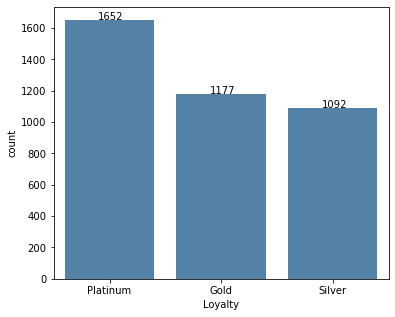

In [40]:
# inspect our loyalty segmentation

df_rfm_loyalty = rfm_loyalty.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.countplot(x="Loyalty", data=df_rfm_loyalty, color='steelblue')

for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [41]:
df_rfm_loyalty.to_csv('retail_loyalty_rfm.csv', index=False)

In [42]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to best fit the chart

df_rfm_loyalty = (rfm_loyalty
    .filter(F.col("Monetary") < 5000)
    .filter(F.col("Frequency") < 500)
).toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

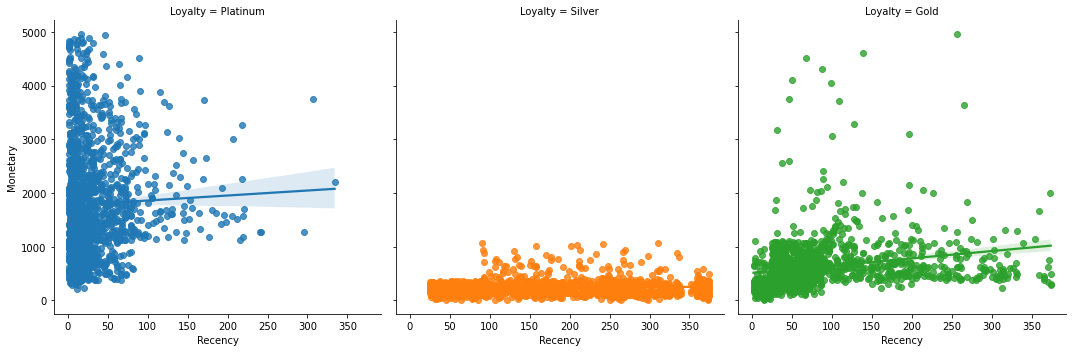

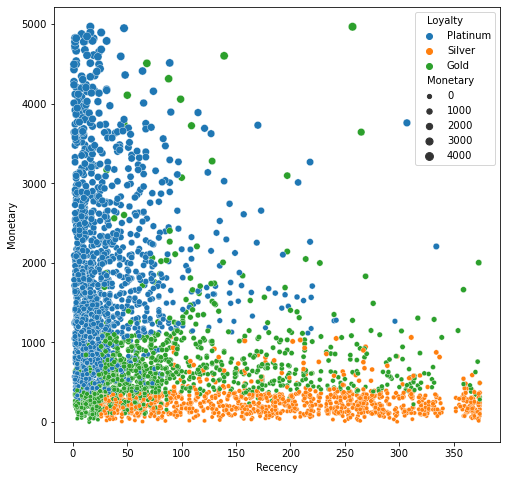

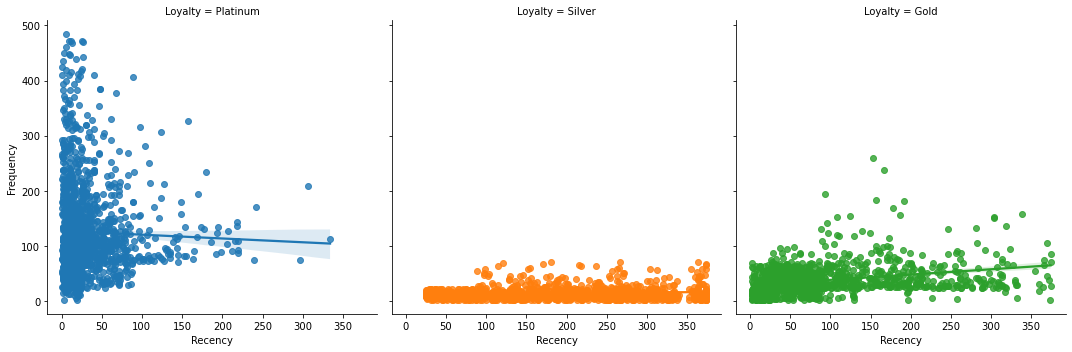

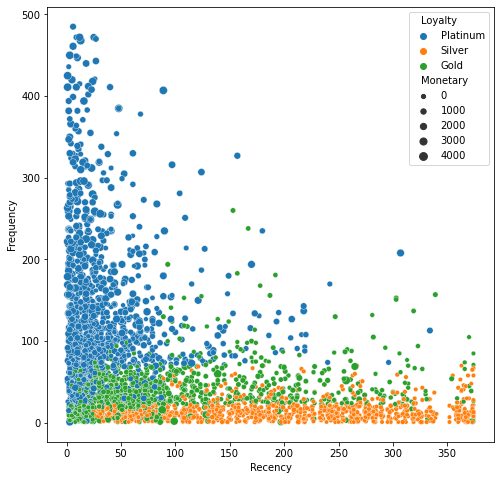

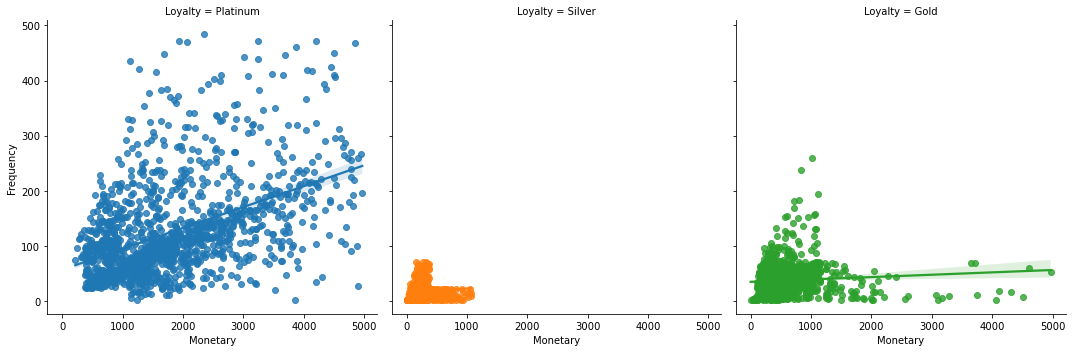

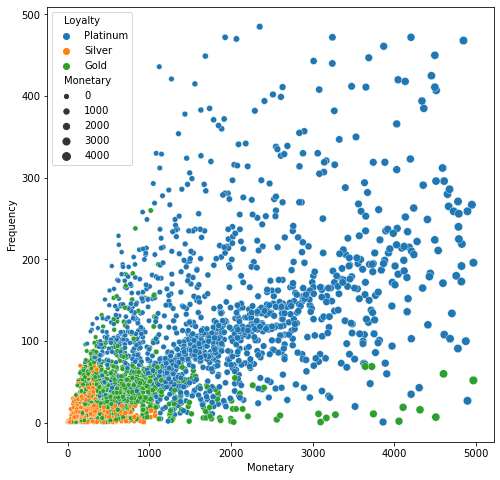

In [43]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Segmentation 2

Assign loyalty level to each customer

Champion: Loyal Customers, they are the champions with highest score of RFM.

Potential: Customers who have the most potential to become the Champions.
           They recently shopped and their purchases frequency is high as well. 
           Moreover, the amount they spent is quite good.
           
Require Attention: Customers who used to shop a lot with high money. but they did not purchase recently. 

Lost: Customers who haven't paid a visit to the store for a long time.


In [44]:
segments = {
    'Champion':['111'], 
    'Potential':['112','113','121','131','123','122','133','132'], 
    'Need Attention':['211','221','231','232','213','212','233','223','222'],
    'Lost':['312','321','331','311','333','332','323','322','313']
}

rfm_segment = (rfm_agg_scores
    .withColumn("Segment",
                F.when((F.col("RFM_ScoreGroup").isin(segments['Champion'])), F.lit('Champion'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Potential'])), F.lit('Potential'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Need Attention'])), F.lit('Need Attention'))
                 .otherwise(F.lit('Lost'))))

In [45]:
printdf(rfm_segment)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_ScoreGroup,Segment
0,12346,326,1,77184.0,3,3,1,7,331,Lost
1,12747,3,103,4207.0,1,1,1,3,111,Champion
2,12748,1,4596,33956.0,1,1,1,3,111,Champion
3,12749,4,199,4115.0,1,1,1,3,111,Champion
4,12820,4,59,946.0,1,2,2,5,122,Potential


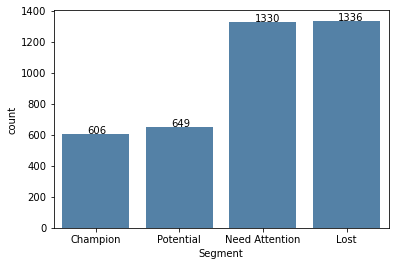

In [46]:
df_rfm_segment = rfm_segment.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# sns.histplot(df_rfm_loyalty["Loyalty"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=df_rfm_segment, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [47]:
rfm_loyalty.write.format("csv").save('retail_loyalty_rfm_spark.csv')
df_rfm_segment.to_csv('retail_rfm_segment.csv', index=False)

# Visualize

In [48]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to optimize the chart

df_rfm_segment = (rfm_segment
    .filter(F.col("Monetary") < 5000)
    .filter(F.col("Frequency") < 500)
).toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

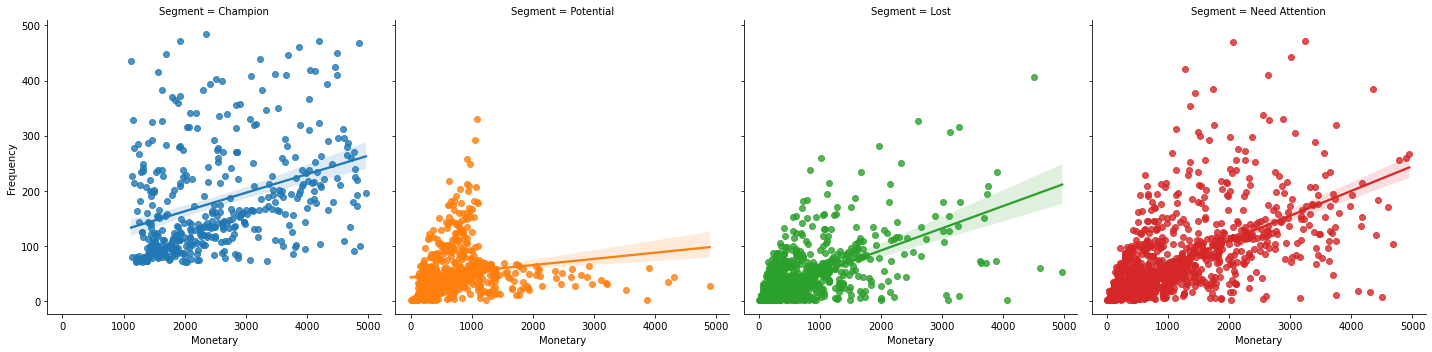

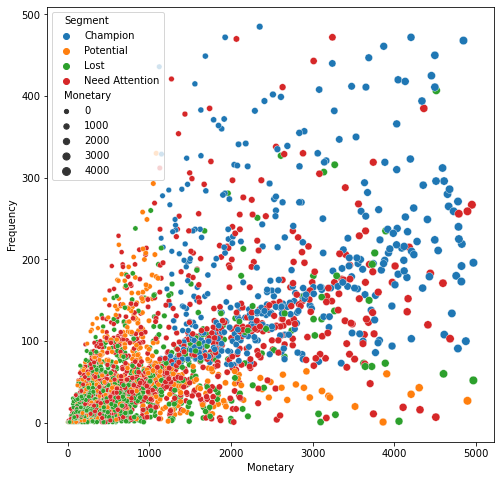

In [49]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_segment, hue='Segment', size='Monetary')

<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

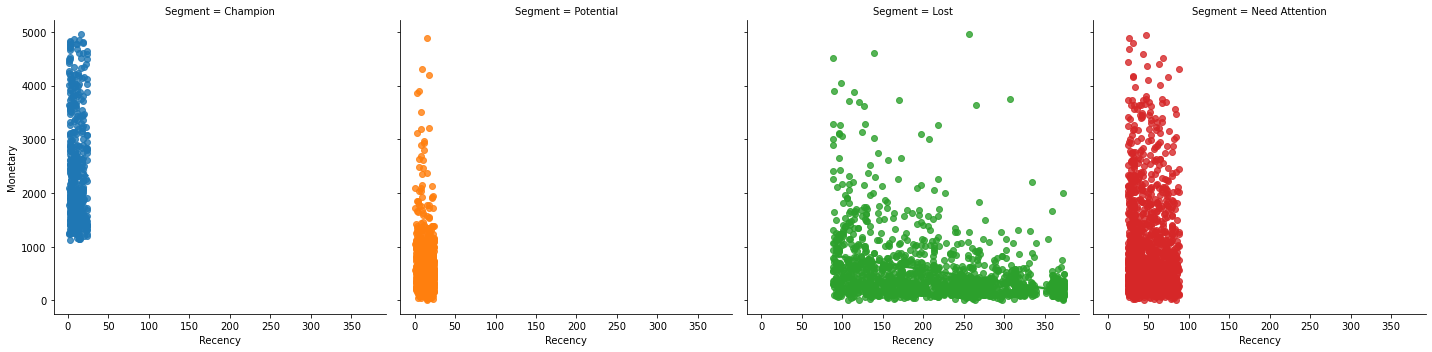

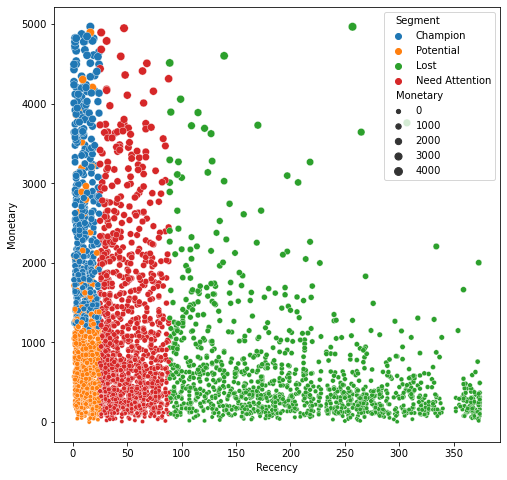

In [50]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_segment, hue='Segment', size='Monetary')

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

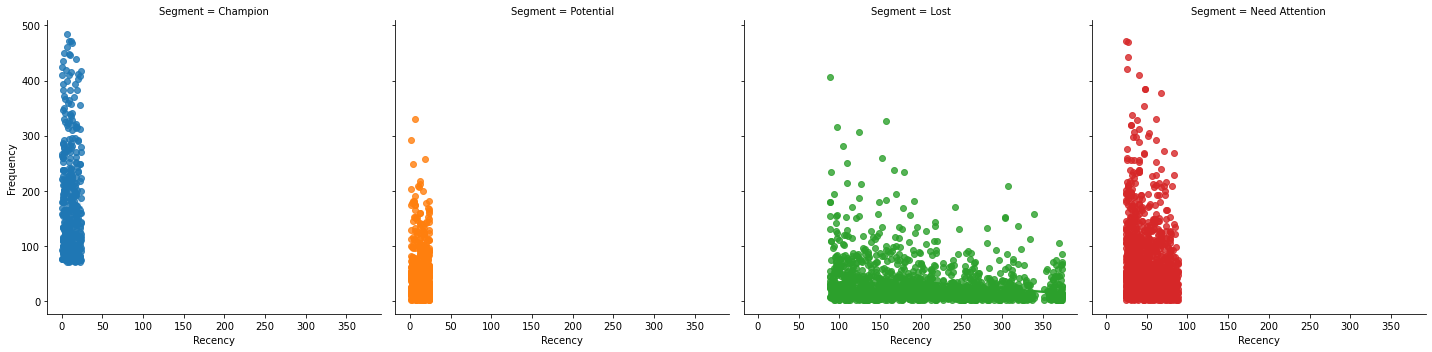

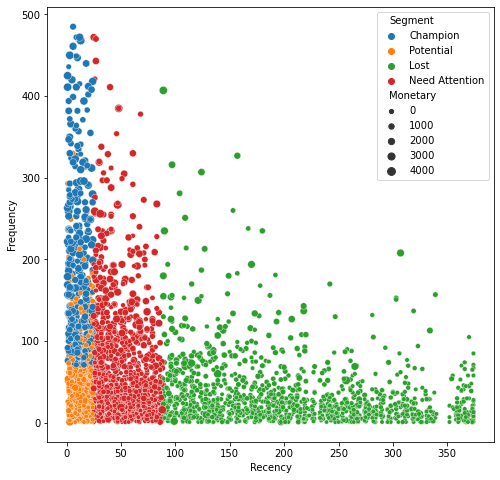

In [51]:
# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_segment, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Recency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_segment, hue='Segment', size='Monetary')

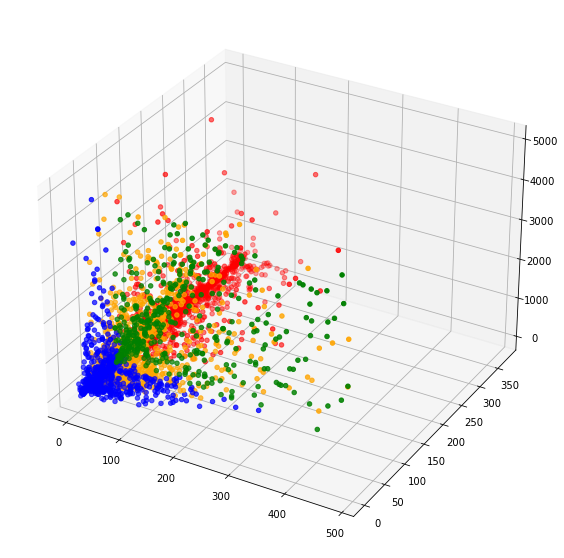

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

colors = {'Champion':'green', 
          'Potential':'blue', 
          'Need Attention':'orange', 
          'Lost':'red'}

ax.scatter(xs=df_rfm_segment.Frequency, 
           ys=df_rfm_segment.Recency, 
           zs=df_rfm_segment.Monetary, 
           c=[colors[x] for x in df_rfm_segment.Segment])